In [2]:
import os
import wandb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(font_scale=1.5, style='whitegrid', palette=sns.color_palette('tab10'))

In [3]:
from typing import List

def get_metrics(sweep_id, keys=None, config_keys=None):
  api = wandb.Api()
  sweep = api.sweep(sweep_id)

  if isinstance(keys, list):
    keys.extend(['_runtime', '_step', '_timestamp'])
    keys = list(set(keys))

  data = []
  for run in sweep.runs:
    cfg = {k: run.config[k] for k in config_keys}
    for row in run.scan_history(keys=keys):
      data.append(dict(run_id=run.id, **cfg, **row))

  return sweep, pd.DataFrame(data)

In [4]:
keys = None ## get everything

## KeOps
_, metrics1 = get_metrics('gausspr/simplex-gp/xt1i60t7', keys=keys, config_keys=['method', 'dataset'])

## Simplex-GP
_, metrics2 = get_metrics('gausspr/simplex-gp/wz0yzdqq', keys=keys, config_keys=['method', 'dataset'])

metrics = pd.concat([metrics1, metrics2])
metrics['train/total_cu_ts'] = metrics.groupby(by=['run_id'])['train/total_ts'].cumsum()
metrics

,run_id,method,dataset,train/bw_ts,_step,param/lengthscale/7,param/lengthscale/4,param/lengthscale/1,train/loss_ts,param/lengthscale/8,...,param/lengthscale/14,param/lengthscale/17,param/lengthscale/12,param/lengthscale/18,param/lengthscale/16,param/lengthscale/11,param/lengthscale/15,param/lengthscale/13,param/lengthscale/19,train/total_cu_ts
0,zkp9rqw0,KeOps,houseelectric,105.363387,1,0.744397,0.744397,0.744397,503.457881,0.744396,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,608.821267
1,zkp9rqw0,KeOps,houseelectric,86.473207,2,0.797936,0.797945,0.797994,575.120489,0.797946,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1270.414962
2,zkp9rqw0,KeOps,houseelectric,86.003950,3,0.853659,0.853626,0.853807,587.565592,0.853618,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1943.984505
3,zkp9rqw0,KeOps,houseelectric,86.436040,4,0.911163,0.911127,0.911585,746.560068,0.911106,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2776.980613
4,zkp9rqw0,KeOps,houseelectric,86.360638,5,0.970235,0.970302,0.971183,745.078271,0.970179,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3608.419522
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
518,4u1sqq3g,BiGP,protein,2.990799,96,0.235212,0.190593,2.148667,6.318243,0.432261,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,860.262183
519,4u1sqq3g,BiGP,protein,2.991076,97,0.229921,0.192609,2.157308,6.262855,0.439760,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,869.516114
520,4u1sqq3g,BiGP,protein,2.999412,98,0.222917,0.193562,2.165801,6.293107,0.445433,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,878.808632
521,4u1sqq3g,BiGP,protein,2.991908,99,0.216929,0.192909,2.174223,6.419450,0.451990,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,888.219990


## Runtime, RMSE, MLL

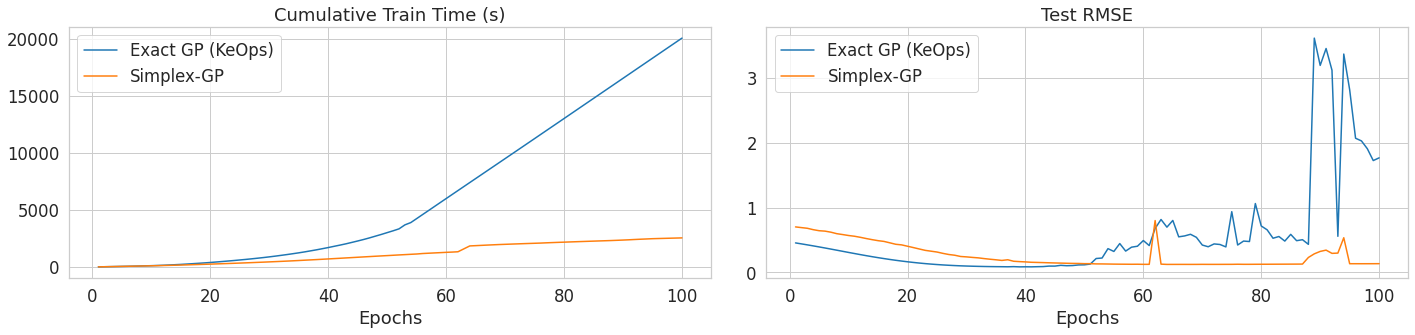

In [21]:
# fig, axes = plt.subplots(figsize=(10, 10), nrows=2, ncols=2)
fig, axes = plt.subplots(figsize=(20, 5), ncols=2, sharex=True)

dataset = '3droad'
plt_metrics = metrics[(metrics.dataset == dataset) & (metrics._step <= 100)]
plt_metrics = plt_metrics.sort_values(by=['method'], ascending=False)
# sns.lineplot(data=plt_metrics, x='_step', y='train/mll', hue='method', ci=None, ax=axes[0,0])
sns.lineplot(data=plt_metrics, x='_step', y='train/total_cu_ts', hue='method', ci=None, ax=axes[0])
# sns.lineplot(data=plt_metrics, x='_step', y='val/rmse', hue='method', ci=None, ax=axes[1,0])
sns.lineplot(data=plt_metrics, x='_step', y='test/rmse', hue='method', ci=None, ax=axes[1])

axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('')
axes[0].set_title('Cumulative Train Time (s)')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('')
axes[1].set_title('Test RMSE')
h, l = axes[0].get_legend_handles_labels()
axes[0].legend(h, ['Exact GP (KeOps)', 'Simplex-GP'])
h, l = axes[1].get_legend_handles_labels()
axes[1].legend(h, ['Exact GP (KeOps)', 'Simplex-GP'])

# axes[1,0].set_ylim([0.0, 2.0])
# axes[1,1].set_ylim([0.0, 2.0])

fig.tight_layout()

# ax.set_ylim([0., 2.])
# fig.savefig('3droad-train.pdf', bbox_inches='tight')
# fig.savefig(f'{dataset}-training.png', bbox_inches='tight')

## Lengthscales and Noise

In [ ]:
def raw2label(v):
  l = v.split('/')[-1]
  if l == 'outputscale':
    return r'$\alpha$'
  elif l == 'noise':
    return r'$\sigma^2$'
  else:
    return fr'$\ell_{{{l}}}$'

dataset = 'houseelectric'
# plt_metrics = metrics[(metrics.dataset == dataset) & (metrics._step == step)].dropna(axis=1)
plt_metrics = metrics[(metrics.dataset == dataset)].dropna(axis=1)
param_columns = list(filter(lambda x: 'param/lengthscale' in x, plt_metrics.columns))
plt_metrics = plt_metrics[['run_id', 'method', 'dataset', '_step'] + param_columns]
plt_metrics = plt_metrics.melt(id_vars=['run_id', 'method', 'dataset', '_step'], var_name='param', value_name='param_value')
plt_metrics = plt_metrics.sort_values(by=['method', 'param_value'], ascending=False)

fig, ax = plt.subplots(figsize=(20, 5))
# fig, ax = plt.subplots()
sns.barplot(data=plt_metrics, x='param', y='param_value', hue='method', ax=ax)
ax.set_xticklabels([raw2label(t.get_text()) for t in ax.get_xticklabels()])
ax.set_xlabel('')
ax.set_ylabel('')
fig.savefig(f'{dataset}-ls.png', bbox_inches='tight')

In [ ]:
def raw2label(v):
  l = v.split('/')[-1]
  if l == 'outputscale' or l == 'noise':
    return l
  else:
    return fr'$\ell_{{{l}}}$'

dataset = 'houseelectric'
plt_metrics = metrics[(metrics.dataset == dataset)].dropna(axis=1)
param_columns = ['param/outputscale', 'param/noise']
plt_metrics = plt_metrics[['run_id', 'method', 'dataset', '_step'] + param_columns]
plt_metrics = plt_metrics.melt(id_vars=['run_id', 'method', 'dataset', '_step'], var_name='param', value_name='param_value')
plt_metrics = plt_metrics.sort_values(by=['method', 'param_value'], ascending=False)

fig, ax = plt.subplots()
sns.barplot(data=plt_metrics, x='param', y='param_value', hue='method', ax=ax)
ax.set_xticklabels([raw2label(t.get_text()) for t in ax.get_xticklabels()])
ax.set_xlabel('')
ax.set_ylabel('')
fig.savefig(f'{dataset}-scale_noise.png', bbox_inches='tight')

## CG Truncation

In [ ]:
## Simplex-GP CG Truncations with noise
sweep, metrics = get_metrics('gausspr/simplex-gp/ovlqyu20',
                         keys=['train/total_ts', 'train/mll', 'val/rmse', 'test/rmse'],
                         config_keys=['dataset', 'cg_iter'])

metrics['train/total_cu_ts'] = metrics.groupby(by=['run_id'])['train/total_ts'].cumsum()
metrics

In [ ]:
rmse_data = []
for run in sweep.runs:
    rmse_data.append({ 'dataset': run.config['dataset'], 'cg_iter': run.config['cg_iter'], 'best_rmse': run.summary['test/best_rmse'] })
rmse_data = pd.DataFrame(rmse_data)
rmse_data[rmse_data.dataset == 'protein']

In [ ]:
fig, axes = plt.subplots(figsize=(10, 10), nrows=2, ncols=2)

dataset = 'protein'
plt_metrics = metrics[(metrics.dataset == dataset) & (metrics._step <= 100)]
plt_metrics = plt_metrics.sort_values(by=['cg_iter'])
# plt_metrics = plt_metrics[plt_metrics['train/mll'] != 'NaN']
plt_metrics.loc[:, 'train/mll'] = pd.to_numeric(plt_metrics['train/mll'])

sns.lineplot(data=plt_metrics, x='_step', y='train/mll', hue='cg_iter', ax=axes[0,0])
sns.lineplot(data=plt_metrics, x='_step', y='train/total_cu_ts', hue='cg_iter', ax=axes[0,1])
sns.lineplot(data=plt_metrics, x='_step', y='val/rmse', hue='cg_iter', ax=axes[1,0])
sns.lineplot(data=plt_metrics, x='_step', y='test/rmse', hue='cg_iter', ax=axes[1,1])
fig.tight_layout()

# fig.savefig(f'{dataset}-cg-iter.png', bbox_inches='tight')